# 21cm Sensitivity Plots

## Load

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload
import darkhistory.physics as phys

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from astropy.io import fits

import numpy as np
import copy
import pickle
import darkhistory.spec.spectools as spectools
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d

import main

here?
****** Loading transfer functions... ******
    for high-energy photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy...  Done!
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** All transfer functions loaded! ******


Load standard solution

In [4]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

FileNotFoundError: [Errno 2] No such file or directory: '../darkhistory/history/std_soln.p'

### Download xe_idl

In [9]:
user = '/Users/gregoryridgway'
direc = user+'/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'

hdul = fits.open(direc+'elec/tf_z_3.000E+03_nstep_6398_logE_1.067E+01_xe_0.000E+00.fits')
# direc = direc+inj_str

data = hdul[1].data

idl_redshift = data.field('redshift')[0]
xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

### Structure Formation

In [10]:
struct_boost_einasto = phys.struct_boost_func('einasto_with_subs')

## $T_{21}$ input

Calculate upper bound for $T_m$ using 
$$
    T_\text{21}(z) \approx (1-\frac{T_R}{T_S})
$$
where the constant of proportionality is given by 
$$
    \sqrt{\frac{.15}{10}} ...
$$
and we have assumed $T_R(z) = T_\text{CMB}(z)$ 

Calculate the $T_{IGM}$ bound, $T_\text{bnd}$ provided a measurement of $T_{21}$.  Assume $x_e \approx 2\times 10^{-4}$

In [11]:
T_21 = -50 #in mK
end_rs = 1 + 17.2
num = np.sqrt(.15/10/phys.omega_m*end_rs)*(phys.omega_baryon*phys.h/.02)*(1-2e-4)*23
one_minus_ratio = T_21 / num
Tm_bnd = phys.TCMB(end_rs)/(1-one_minus_ratio)/phys.kB
print("T_m < ", Tm_bnd, "K")

T_m <  20.486287254367387 K


# Scan through $m_\chi$ and $\tau$ or $\sigma v$

## swave annihilation

Specify type of injection (swave or decay) and products ($e^+e^-$ or $\gamma\gamma$)

In [12]:
inj_particle = 'photon'
inj_str = inj_particle[:4]
inj_type = 'swave'

if inj_type == 'swave':
    struct_boost = struct_boost_einasto
    struct_func = struct_boost
else:
    def struct_boost(rs):
        return 1
    struct_func = None
    
if inj_particle == 'photon':
    mass = 0
    coarsen_factor=4
else:
    mass = phys.me
    coarsen_factor=12

rs_init = 3000

Given a dark matter mass and $\tau$ or $\sigma v$, calculate $T(z=17.2)$.

In [19]:
def get_T(mDM, log10_p, backreaction):
    if inj_type == 'decay':
        Einj = mDM/2-mass
        Ecom=mDM
    if inj_type == 'swave':
        Einj = mDM - mass
        Ecom = 2*mDM
        
    if inj_particle == 'photon':
        primary = 'phot_delta'
    else:
        primary = 'elec_delta'

    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, tau=10**log10_p, sigmav=10**log10_p*mDM/1e9)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, tau=10**log10_p, sigmav=10**log10_p*mDM/1e9)*struct_boost(rs)

    a = main.evolve(
            primary=primary,
            rate_func_N=rate_func_N, rate_func_eng=rate_func_eng,
            DM_process=inj_type, mDM=mDM, sigmav=10**log10_p*mDM/1e9, lifetime=10**log10_p,
            start_rs = 3000, end_rs=end_rs,
            coarsen_factor=coarsen_factor, backreaction=backreaction,
            struct_boost=struct_boost
    )
    return a['Tm'][-1]/phys.kB

Set up a $(m_\chi, \tau \text{ or } \sigma v)$ grid over which to scan

In [20]:
%autoreload
step = .25
if inj_particle == 'photon':
    mbnds = [4,12.5]
    log10mDM_arr = np.arange(mbnds[0], mbnds[1], step)

    if inj_type == 'decay':
        parambnds = [23,28.25 + step] #tau
        param_guess = 27
    else:
        parambnds = [-28,-25 + step] # sigma v / mDM
        param_guess = -26.5
else:
    mbnds = [6.01,12.51]
    log10mDM_arr = np.arange(mbnds[0], mbnds[1], step)

    if inj_type == 'decay':
        parambnds = [24,28.25 + step]
        param_guess = 27
    else:    
        parambnds = [-30.5,-24.5 + step]
        param_guess = -26
    
log10_param = np.arange(parambnds[0], parambnds[1], step)

Conduct the scan without back-reaction.

Loop a grid of $E_\text{inj}$ values, $E^i_\text{inj}$.  
For the first grid value, $E^0_\text{inj}$, provide a guess (`param_guess`) for the $\tau$ or $\langle \sigma v \rangle$ that leads to $T_m(z=17.2)$ attaining its bound.  If the guess led to $T_m(z=17.2) > T_\text{bnd}$, increase $\tau$ or decrease $\langle \sigma v \rangle$.  If $T_m(z=17.2) < T_\text{bnd}$, decrease $\tau$ or increase $\langle \sigma v \rangle$.  Repeat this process until $T_m(z=17.2)$ crosses the bound once.

For the next injection energies set `param_guess` to the value that $\tau$ or $\langle \sigma v \rangle$ arrived at in the previous step and repeat.

In [21]:
%autoreload
T_IGM_17_std = np.zeros((log10mDM_arr.size, log10_param.size))

for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    print('log10(mDM): ', log10mDM)
    mDM = 10**log10mDM
    j=len(log10_param[log10_param < param_guess])
    above=False
    below=False

    while((not below) or (not above)):
        log10_p = log10_param[j]
        print('log10(param): ', log10_p)

        T_std = get_T(mDM, log10_p, backreaction=False)
        T_IGM_17_std[i,j] = T_std
        print('T_0 [K]: ', T_std)

        if T_std > Tm_bnd:
            above = True
            print("T_std Above Threshold")
            j = j-1
        else:
            below = True
            print("T_std Below Threshold")
            j = j+1
            
        param_guess = log10_p        
                    
pickle.dump(
    T_IGM_17_std, 
    open('/Users/gregoryridgway/Desktop/T_IGM_17_'+
         inj_str+'_'+inj_type+'_std_coarsen'+str(coarsen_factor)+'.dat','wb')
)

log10(mDM):  4.0
log10(param):  -27.0


T_0 [K]:  11.107332593701221
T_std Below Threshold
log10(param):  -26.75


T_0 [K]:  13.226996011440539
T_std Below Threshold
log10(param):  -26.5


T_0 [K]:  16.426119416647378
T_std Below Threshold
log10(param):  -26.25


T_0 [K]:  21.427867843788434
T_std Above Threshold
log10(mDM):  4.25
log10(param):  -26.25


KeyboardInterrupt: 

Linearly interpolate over the parameter values to find the $\tau$ or $\sigma$ that saturates the $T_m(z=17.2)$ bound.

In [47]:
def find_param(Tlist):
    if inj_type == 'swave':
        above = np.nonzero(Tlist > Tm_bnd)[0][-1]
        below = above-1
    else:
        above = np.nonzero(Tlist > Tm_bnd)[0][0]
        below = above+1
    Ts = [Tlist[below], Tlist[above]]
    ps = [log10_param[below], log10_param[above]]
    return (np.diff(ps)/np.diff(Ts)*(Tm_bnd-Ts[0]) + ps[0])[0]

thresh_params_std = np.array(
    [find_param(T_IGM_17_std[i]) for i in np.arange(len(T_IGM_17_std))]
)

Conduct the scan with back-reaction

In [697]:
%autoreload
T_IGM_17_BR = np.zeros((log10mDM_arr.size, log10_param.size))
param_guess = thresh_params_std[0]

for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    print('log10(mDM): ', log10mDM)
    mDM = 10**log10mDM
    j=len(log10_param[log10_param < param_guess])
    above=False
    below=False

    while((not below) or (not above)):
        log10_p = log10_param[j]
        print('log10(param): ', log10_p)

        T_BR = get_T(mDM, log10_p, backreaction=True)
        T_IGM_17_BR[i,j] = T_BR
        print('T_0 [K]: ', T_BR)

        if T_BR > Tm_bnd:
            above = True
            print("T_BR Above Threshold")
            if inj_type == 'swave':
                j = j-1
            else:
                j = j+1
        else:
            below = True
            print("T_BR Below Threshold")
            if inj_type == 'swave':
                j = j+1
            else:
                j = j-1
        param_guess = log10_p
        
                    
pickle.dump(
    T_IGM_17_BR, 
    open('/Users/gridgway/Desktop/T_IGM_17_'+
         inj_str+'_'+inj_type+'_BR_coarsen'+str(coarsen_factor)+'.dat','wb')
)

log10(mDM):  4.0
log10(param):  -26.25


T_0 [K]:  24.662944508117597
T_BR Above Threshold
log10(param):  -26.5


T_0 [K]:  17.883355062372658
T_BR Below Threshold
log10(mDM):  4.25
log10(param):  -26.5


T_0 [K]:  15.714742741613685
T_BR Below Threshold
log10(param):  -26.25


T_0 [K]:  20.71294074727853
T_BR Above Threshold
log10(mDM):  4.5
log10(param):  -26.25


T_0 [K]:  20.100302328750907
T_BR Below Threshold
log10(param):  -26.0


T_0 [K]:  28.2985550450351
T_BR Above Threshold
log10(mDM):  4.75
log10(param):  -26.0


T_0 [K]:  29.14002409784055
T_BR Above Threshold
log10(param):  -26.25


T_0 [K]:  20.41564196173362
T_BR Below Threshold
log10(mDM):  5.0
log10(param):  -26.25


T_0 [K]:  21.50450473414991
T_BR Above Threshold
log10(param):  -26.5


T_0 [K]:  15.859801934712328
T_BR Below Threshold
log10(mDM):  5.25
log10(param):  -26.5


T_0 [K]:  16.0009742417345
T_BR Below Threshold
log10(param):  -26.25


T_0 [K]:  21.988833670834367
T_BR Above Threshold
log10(mDM):  5.5
log10(param):  -26.25


T_0 [K]:  20.35087313395289
T_BR Below Threshold
log10(param):  -26.0


T_0 [K]:  29.916998703070504
T_BR Above Threshold
log10(mDM):  5.75
log10(param):  -26.0


T_0 [K]:  24.38453826009741
T_BR Above Threshold
log10(param):  -26.25


T_0 [K]:  17.21933418859081
T_BR Below Threshold
log10(mDM):  6.0
log10(param):  -26.25


T_0 [K]:  13.536523728120153
T_BR Below Threshold
log10(param):  -26.0


T_0 [K]:  17.901937793608997
T_BR Below Threshold
log10(param):  -25.75


T_0 [K]:  25.507247163854935
T_BR Above Threshold
log10(mDM):  6.25
log10(param):  -25.75


T_0 [K]:  18.404517864134625
T_BR Below Threshold
log10(param):  -25.5


T_0 [K]:  26.153317543717204
T_BR Above Threshold
log10(mDM):  6.5
log10(param):  -25.5


T_0 [K]:  18.152760865067528
T_BR Below Threshold
log10(param):  -25.25


T_0 [K]:  25.003563453183254
T_BR Above Threshold
log10(mDM):  6.75
log10(param):  -25.25


T_0 [K]:  19.298772837058603
T_BR Below Threshold
log10(param):  -25.0


/Users/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


T_0 [K]:  26.046931097749148
T_BR Above Threshold
log10(mDM):  7.0
log10(param):  -25.0


T_0 [K]:  25.719263982414013
T_BR Above Threshold
log10(param):  -25.25


T_0 [K]:  19.440774739753795
T_BR Below Threshold
log10(mDM):  7.25
log10(param):  -25.25


T_0 [K]:  31.089661543325096
T_BR Above Threshold
log10(param):  -25.5


T_0 [K]:  22.142325401346362
T_BR Above Threshold
log10(param):  -25.75


T_0 [K]:  16.991146131087913
T_BR Below Threshold
log10(mDM):  7.5
log10(param):  -25.75


T_0 [K]:  20.478090506582202
T_BR Above Threshold
log10(param):  -26.0


T_0 [K]:  15.850718371684794
T_BR Below Threshold
log10(mDM):  7.75
log10(param):  -26.0


T_0 [K]:  16.972987777442253
T_BR Below Threshold
log10(param):  -25.75


T_0 [K]:  22.452258054916186
T_BR Above Threshold
log10(mDM):  8.0
log10(param):  -25.75


T_0 [K]:  23.2192457670853
T_BR Above Threshold
log10(param):  -26.0


T_0 [K]:  17.464252242521404
T_BR Below Threshold
log10(mDM):  8.25
log10(param):  -26.0


T_0 [K]:  17.76155872734942
T_BR Below Threshold
log10(param):  -25.75


T_0 [K]:  23.60450448364913
T_BR Above Threshold
log10(mDM):  8.5
log10(param):  -25.75


T_0 [K]:  23.244411130117097
T_BR Above Threshold
log10(param):  -26.0


T_0 [K]:  17.58250374481945
T_BR Below Threshold
log10(mDM):  8.75
log10(param):  -26.0


T_0 [K]:  16.74557402142903
T_BR Below Threshold
log10(param):  -25.75


T_0 [K]:  21.842522548940124
T_BR Above Threshold
log10(mDM):  9.0
log10(param):  -25.75


T_0 [K]:  19.939744964606234
T_BR Below Threshold
log10(param):  -25.5


T_0 [K]:  27.135243101422876
T_BR Above Threshold
log10(mDM):  9.25
log10(param):  -25.5


T_0 [K]:  23.08779037621177
T_BR Above Threshold
log10(param):  -25.75


T_0 [K]:  17.531941889422708
T_BR Below Threshold
log10(mDM):  9.5
log10(param):  -25.75


T_0 [K]:  15.627459782993093
T_BR Below Threshold
log10(param):  -25.5


T_0 [K]:  19.890425543838145
T_BR Below Threshold
log10(param):  -25.25


T_0 [K]:  26.92060998039796
T_BR Above Threshold
log10(mDM):  9.75
log10(param):  -25.25


T_0 [K]:  22.160625871298688
T_BR Above Threshold
log10(param):  -25.5


T_0 [K]:  17.172982718430188
T_BR Below Threshold
log10(mDM):  10.0
log10(param):  -25.5


T_0 [K]:  15.888007256729647
T_BR Below Threshold
log10(param):  -25.25


T_0 [K]:  19.762489421683913
T_BR Below Threshold
log10(param):  -25.0


T_0 [K]:  26.08434481237296
T_BR Above Threshold
log10(mDM):  10.25
log10(param):  -25.0


T_0 [K]:  24.543701298716346
T_BR Above Threshold
log10(param):  -25.25


T_0 [K]:  19.005261150111867
T_BR Below Threshold
log10(mDM):  10.5
log10(param):  -25.25


T_0 [K]:  18.97473968891912
T_BR Below Threshold
log10(param):  -25.0


T_0 [K]:  24.418246942233633
T_BR Above Threshold
log10(mDM):  10.75
log10(param):  -25.0


T_0 [K]:  23.819180852575435
T_BR Above Threshold
log10(param):  -25.25


T_0 [K]:  18.578123470076438
T_BR Below Threshold
log10(mDM):  11.0
log10(param):  -25.25


T_0 [K]:  19.19130639189246
T_BR Below Threshold
log10(param):  -25.0


T_0 [K]:  24.917342906142757
T_BR Above Threshold
log10(mDM):  11.25
log10(param):  -25.0


T_0 [K]:  26.737950585173166
T_BR Above Threshold
log10(param):  -25.25


T_0 [K]:  20.30107339755952
T_BR Below Threshold
log10(mDM):  11.5
log10(param):  -25.25


T_0 [K]:  20.59596503194243
T_BR Above Threshold
log10(param):  -25.5


T_0 [K]:  16.52498206083622
T_BR Below Threshold
log10(mDM):  11.75
log10(param):  -25.5


T_0 [K]:  16.406805392927357
T_BR Below Threshold
log10(param):  -25.25


T_0 [K]:  20.423680358064402
T_BR Below Threshold
log10(param):  -25.0


T_0 [K]:  26.895014185233403
T_BR Above Threshold
log10(mDM):  12.0
log10(param):  -25.0


T_0 [K]:  26.661561210143308
T_BR Above Threshold
log10(param):  -25.25


T_0 [K]:  20.271624834890606
T_BR Below Threshold
log10(mDM):  12.25
log10(param):  -25.25


T_0 [K]:  20.633720051225218
T_BR Above Threshold
log10(param):  -25.5


T_0 [K]:  16.500943324947283
T_BR Below Threshold



### Plots

Make an interpolation function for the points $(m_\text{DM}, \tau_\text{min})$ or $(m_\text{DM}, \sigma_\text{max})$ with and without backreaction.

In [698]:
thresh_params_BR = np.array([find_param(row) for row in T_IGM_17_BR])

std_interp = interp1d(log10mDM_arr, thresh_params_std, kind='quadratic')
BR_interp = interp1d(log10mDM_arr, thresh_params_BR, kind='quadratic')

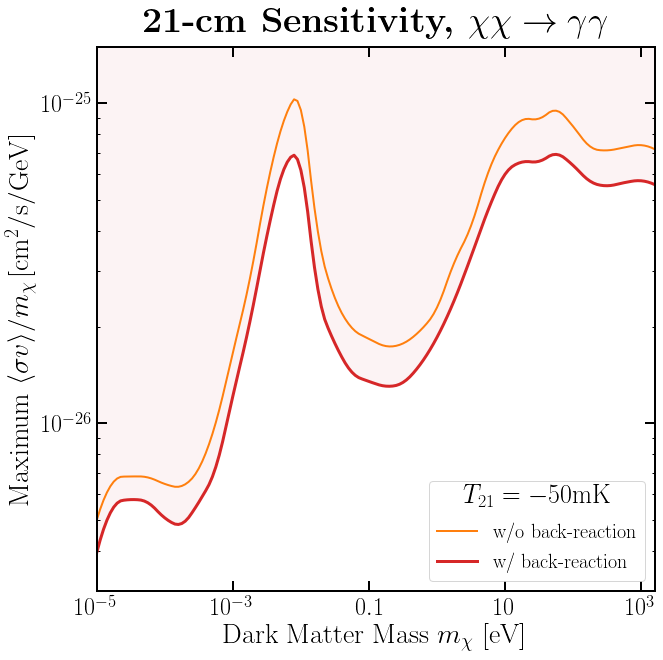

In [703]:
plt.figure()
ax = plt.gca()
ax.loglog()

xmin = 10**log10mDM_arr_fine[0]/1e9
xmax = 10**log10mDM_arr_fine[-1]/1e9

if inj_particle=='electron':
    if inj_type == 'swave':
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \chi \to e^+ e^-$')
        ymin = 5e-29
        ymax = 1e-25
    else:
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \to e^+ e^-$')
        ymin = 2e23
        ymax = 4e26
else:
    if inj_type == 'swave':
        plt.title(r'\bf{21-cm Sensitivity,} $\chi\chi \to \gamma\gamma$')
        ymin = 3e-27
        ymax = 1.5e-25
    else:
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \to \gamma\gamma$')
        ymin = 2e23
        ymax = 4e26
    
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
if inj_type == 'swave':
    plt.ylabel(r'Maximum $\langle \sigma v \rangle / m_\chi \, [\mathrm{ cm^2 / s / GeV}]$')
else:
    plt.ylabel(r'Minimum Lifetime $\tau \, [\mathrm{s}]$')
    
plt.axis([xmin, xmax, ymin, ymax])

plt_std, = plt.plot(10**log10mDM_arr_fine/1e9, 10**std_interp(log10mDM_arr_fine), 
        linewidth=2, label='w/o back-reaction', color='C1')
plt_BR, = plt.plot(10**log10mDM_arr_fine/1e9, 10**BR_interp(log10mDM_arr_fine), 
         linewidth=3, label='w/ back-reaction', color='C3')

ax.fill_between(
    10**log10mDM_arr_fine/1e9, 
    1e-15, 
    (10**BR_interp(log10mDM_arr_fine)), 
    interpolate=True, 
    color='C3',
    alpha=.05
)

leg = plt.legend(handles=[plt_std, plt_BR],
                 fontsize=20,
          title='$T_{21} = -50$mK')
plt.setp(leg.get_title(), fontsize=26)

plt.savefig('/Users/gridgway/Dropbox (MIT)/Photon Deposition/Draft/plots/'+
            'DarkHistory_21cm_Sensitivity_'+inj_type+'_'+inj_str+'.png')